In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import product
import scipy.stats as ss
import pickle
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

pd.options.display.max_rows = 150
pd.options.display.max_columns = 100

In [13]:
df = pd.read_pickle('./datasets/full_us.pkl')

In [6]:
TARGET = 'target_full_ltv_day30'
SUBTARGETS = ['target_sub_ltv_day30', 'target_iap_ltv_day30', 'target_ad_ltv_day30']
time_cols = ['install_date']
cat_cols = ['media_source', 'country_code', 'platform']
num_cols = [col for col in df.columns if col not in [TARGET] + SUBTARGETS + time_cols + cat_cols]

In [7]:
def handle_outliers(df, feature, method='drop'):
    """
    Splits dataset based on the platform and removes outliers using IQR

    Q1 - 1.5 * IQR < X < Q3 + 1.5 * IQR

    Returns splited data
    """
    df = df[df[feature] > 1]
    ios_df = df[df['platform'] == 'ios']
    android_df = df[df['platform'] == 'android']

    ios_q1, ios_q3 = ios_df[feature].quantile(0.25), ios_df[feature].quantile(0.75)
    android_q1, android_q3 = android_df[feature].quantile(0.25), android_df[feature].quantile(0.75)
    
    ios_iqr = ios_q3-ios_q1
    android_iqr = android_q3-android_q1

    ios_lower_bound, ios_upper_bound = ios_q1 - (1.5 * ios_iqr), ios_q3 + (1.5 * ios_iqr)
    android_lower_bound, android_upper_bound = android_q1 - (1.5 * android_iqr), android_q3 + (1.5 * android_iqr)

    print(ios_lower_bound, ios_upper_bound)
    print(android_lower_bound, android_upper_bound)
    
    if method == 'replace':
        ios_df.loc[ios_df[feature] > ios_upper_bound, feature] = ios_q3
        ios_df.loc[ios_df[feature] < ios_lower_bound, feature] = ios_q1

        android_df.loc[android_df[feature] > android_upper_bound, feature] = android_q3
        android_df.loc[android_df[feature] < android_lower_bound, feature] = android_q1

    elif method == 'drop':
        ios_df = ios_df[(ios_df[feature] < ios_upper_bound) & (ios_df[feature] > ios_lower_bound)]
        android_df = android_df[(android_df[feature] < android_upper_bound) & (android_df[feature] > android_lower_bound)]

    return ios_df, android_df

In [8]:
denoised_ios_df, denoised_android_df = handle_outliers(df, TARGET, 'drop')

-5.191566779304925 13.364111999180441
-5.981099748970917 14.872193132591404


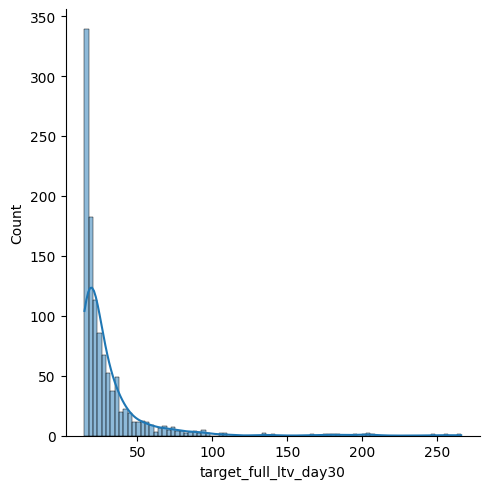

In [15]:
sns.displot(data=df[(df['platform'] == 'android') & (df[TARGET] > 14.8)][TARGET], kde=True)

In [11]:
# %reset_selective denoised_ios_df

Once deleted, variables cannot be recovered. Proceed (y/[n])?   н
Once deleted, variables cannot be recovered. Proceed (y/[n])?   y


In [16]:
# (denoised_android_df.shape[0] + 100000) / df[df['platform'] == 'android'].shape[0]

0.12585950828576128

In [22]:
# print(denoised_android_df.shape[0], df[df['platform'] == 'ios'].shape[0])

NameError: name 'denoised_android_df' is not defined

In [4]:
denoised_android_df = df[df['platform'] == 'android']

In [26]:
def oh_encode_n_popular(df, columns_params={}):
    '''
    Return dataframe with passed category groupby_columns, simplified
    to most popular n values, found in grouped sum of top_col,
    and one-hot encoded.
    
    Parameters
    ----------
    columns_params: Columns, corresponding most popular n values to leave
    and default value in format {groupby_col: (top_col, n, default_value)}.
    
    Info
    ----------
    df: Passed by copy in function. Threfore, edited inside.
    '''
    oh_cols = pd.DataFrame()

    for groupby_col, (top_col, num, default_value) in columns_params.items():
        top_categories = df.groupby(groupby_col)[top_col].sum().sort_values(ascending=False)[:num].index.values
        simplified_col = np.where(df[groupby_col].isin(top_categories), df[groupby_col], default_value)
        oh_col = pd.get_dummies(simplified_col)
        oh_cols = oh_col.join(oh_cols)

    df = df.drop(columns_params.keys(), axis=1)
    df = df.join(oh_cols)

    return df

In [38]:
columns_params = {'media_source': (TARGET, 5, 'SOURCE_000'),
                  'country_code': (TARGET, 5, 'COUNTRY_000')}

# denoised_ios_df = denoised_ios_df.reset_index(drop=True)
denoised_android_df = denoised_android_df.reset_index(drop=True)
# ios = ios.reset_index(drop=True)
# android = android.reset_index(drop=True)

# ios = oh_encode_n_popular(ios, columns_params)
# denoised_ios_df = oh_encode_n_popular(denoised_ios_df, columns_params)
# android = oh_encode_n_popular(android, columns_params)
denoised_android_df = oh_encode_n_popular(denoised_android_df, columns_params)

In [52]:
denoised_android_df.tail()

,retained_day1,retained_day3,retained_day7,target_full_ltv_day30,COUNTRY_000,COUNTRY_13,COUNTRY_141,COUNTRY_155,COUNTRY_38,COUNTRY_72,SOURCE_000,SOURCE_1,SOURCE_10,SOURCE_17,SOURCE_2,SOURCE_4,disc_app_sub_ltv_day3,disc_app_sub_ltv_day1,disc_app_sub_ltv_day0,disc_app_iap_ltv_day3,disc_app_iap_ltv_day1,disc_app_iap_ltv_day0,disc_ad_ltv_day3,disc_ad_ltv_day1,disc_ad_ltv_day0,disc_chapters_finished_day7,disc_chapters_finished_day3,disc_chapters_finished_day1,disc_chapters_finished_day0,disc_chapters_opened_session9,disc_chapters_opened_session3,disc_chapters_opened_session1,disc_chapters_opened_day7,disc_chapters_opened_day3,disc_chapters_opened_day1,disc_chapters_opened_day0,disc_chapters_closed_session9,disc_chapters_closed_session3,disc_chapters_closed_session1,disc_chapters_closed_day7,disc_chapters_closed_day3,disc_chapters_closed_day1,disc_chapters_closed_day0,disc_diamonds_received_day7,disc_diamonds_received_day3,disc_diamonds_received_day1,disc_diamonds_received_day0,disc_diamonds_spent_day7,disc_diamonds_spent_day3,disc_diamonds_spent_day1,disc_diamonds_spent_day0,disc_tickets_spent_day7,disc_tickets_spent_day3,disc_tickets_spent_day1,disc_tickets_spent_day0,disc_tickets_spent_session9,disc_tickets_spent_session3,disc_tickets_spent_session1,disc_diamonds_spent_session9,disc_diamonds_spent_session3,disc_diamonds_spent_session1,disc_total_sessions_day7,disc_total_sessions_day3,disc_total_sessions_day1,disc_total_sessions_day0,disc_chapters_finished_session9,disc_chapters_finished_session3,disc_chapters_finished_session1
887421,1,0,0,4.820489,0,0,0,1,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.000000,0.0,4.394029,0.000000,0.0,0.426460,0,0,6,12,2,1,-14,0,0,7,12,0,0,0,0,0,0,0,0,0,34,313,0,0,99,244,0,0,4,11,2,1,4,12,12,48,0.0,0.0,7.0,13.0,2,0,5
887422,1,0,0,3.659224,0,0,0,1,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.000000,0.0,3.335499,0.000000,0.0,0.323725,0,0,6,12,2,1,-14,0,0,7,12,0,0,0,0,0,0,0,0,0,34,313,0,0,99,244,0,0,4,11,2,1,4,12,12,48,0.0,0.0,7.0,13.0,2,0,5
887423,1,1,0,6.726134,1,0,0,0,0,0,1,0,0,0,0,0,0.0,0.0,0.0,2.541390,0.0,4.171699,0.000000,0.0,0.013045,2,4,6,7,7,0,-18,1,4,6,8,0,0,-3,1,1,1,0,29,182,50,495,58,189,259,244,1,4,6,7,7,0,0,227,17,0,1.0,8.0,7.0,9.0,7,0,0
887424,0,1,1,78.376447,0,0,1,0,0,0,0,1,0,0,0,0,0.0,0.0,0.0,4.331683,0.0,3.567268,0.100083,0.0,0.079232,17,8,0,9,4,5,-34,17,8,0,11,0,0,-1,0,1,0,1,583,321,0,339,581,395,0,252,12,5,0,5,1,4,0,114,138,0,24.0,9.0,0.0,9.0,3,6,0
887425,1,0,0,4.064295,0,0,1,0,0,0,0,1,0,0,0,0,0.0,0.0,0.0,0.000000,0.0,3.949385,0.000000,0.0,0.114909,0,0,0,15,6,1,-7,0,0,1,15,0,0,0,0,0,0,0,0,0,1,312,0,0,0,255,0,0,0,12,5,0,7,100,12,143,0.0,0.0,1.0,6.0,6,0,9


In [41]:
def get_target_columns(df, feature):
    '''
    Returns sorted list of cummulative columns for feature

    Ex. 
        For total_sessions_day returns:
        [total_sessions_day0, total_sessions_day1, total_sessions_day3, ...]
    '''
    cummulative_columns = [col for col in df.columns if (feature in col and col not in [TARGET]+SUBTARGETS)]
    cummulative_columns.sort()

    return cummulative_columns

def transform_cumulative_to_discrete(df, feature, prefix='disc'):
    '''
    Appends discrete columns to the df and returns transformed df
    '''
    target_cols = get_target_columns(df, feature)
    target_cols = [col for col in target_cols if prefix not in col]
    target_cols.sort()
    transformed_cols = []

    for i in reversed(range(len(target_cols))):
        col = target_cols[i]
        new_col = f'{prefix}_{col}'

        if i == 0:
            df[new_col] = df[col]
        else:
            prev_col = target_cols[i - 1]
            df[new_col] = df[col] - df[prev_col] 

        transformed_cols.append(new_col)

    df = df.drop(columns=target_cols)

    return df

def transform_all_cumulative(df, features):
    for feature in features:
        df = transform_cumulative_to_discrete(df, feature)

    return df

In [42]:
CUMULATIVE_COLUMNS = [
    'app_sub_ltv_day', 'app_iap_ltv_day', 'ad_ltv_day',
    'chapters_finished_day', 'chapters_opened', 'chapters_closed', 'diamonds_received_day',
    'diamonds_spent_day', 'tickets_spent_day', 'tickets_spent_session',
    'diamonds_spent_session', 'total_sessions_day', 'chapters_finished_session',
    'chapters_opened_session', 'chapters_closed_session'
    ]

# denoised_ios_df = transform_all_cumulative(denoised_ios_df, CUMULATIVE_COLUMNS)
denoised_android_df = transform_all_cumulative(denoised_android_df, CUMULATIVE_COLUMNS)

In [46]:
# stratify_ios = pd.cut(denoised_ios_df[TARGET].rank(method='first'), bins=10, labels=False)
stratify_android = pd.cut(denoised_android_df[TARGET].rank(method='first'), bins=10, labels=False)

In [51]:
TO_DROP = ['install_date', 'platform'] + SUBTARGETS

# denoised_ios_df_train = denoised_ios_df.drop(columns=TO_DROP)
denoised_android_df = denoised_android_df.drop(columns=TO_DROP, axis=1)

KeyError: "['install_date', 'platform', 'target_sub_ltv_day30', 'target_iap_ltv_day30', 'target_ad_ltv_day30'] not found in axis"

In [53]:
# X_train_ios, X_test_ios, y_train_ios, y_test_ios = train_test_split(denoised_ios_df.drop(TARGET, axis=1), denoised_ios_df[TARGET], test_size=0.1, random_state=42, shuffle=True, stratify=None)
X_train_android, X_test_android, y_train_android, y_test_android = train_test_split(denoised_android_df.drop(TARGET, axis=1), denoised_android_df[TARGET], test_size=0.1, random_state=42, shuffle=True, stratify=stratify_android)

In [54]:
android_dict = {'train': [X_train_android, y_train_android],
                'test': [X_test_android, y_test_android]}

In [55]:
def save_obj_pkl(obj, f_name):
    with open(f_name, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [56]:
save_obj_pkl(android_dict, './datasets/android_dict.pkl')

In [60]:
android_dict['test'][1].shape[0]

88743